# predicting OnMarket 

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from datetime import timedelta
import ast
import json    
import missingno as msno
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Helper packages
from plotnine import *

# Modeling packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm


In [207]:
df = pd.read_csv('../data/ML.csv')
df['user_id'] = df['user_id'].astype('object')

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          6102 non-null   object 
 1   id               6102 non-null   int64  
 2   len_of_title     6102 non-null   int64  
 3   price            6102 non-null   int64  
 4   len_of_content   6102 non-null   int64  
 5   img_in_posd      6102 non-null   int64  
 6   beds             6102 non-null   int64  
 7   livings          6102 non-null   float64
 8   wc               6102 non-null   int64  
 9   area             6102 non-null   float64
 10  street_width     6102 non-null   float64
 11  age              6102 non-null   float64
 12  ketchen          6102 non-null   float64
 13  ac               6102 non-null   float64
 14  furnished        6102 non-null   float64
 15  district         6102 non-null   object 
 16  advertiser_type  6102 non-null   object 
 17  review        

delete outliers FROM EDA

In [209]:
df =df[df['beds'] <=5]
df = df.loc[(df['review'] > 3) | (df['review'] == 1)]
df = df[df['price'] <=100*1000]
df = df[df['isRent']==True]
df = df[df['onMarket']<=75]

In [210]:
df.drop(['createYEAR'],axis=1 ,inplace=True)
df.drop(['createDAY'],axis=1 ,inplace=True)
df.drop(['createMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateDAY'],axis=1 ,inplace=True)
df.drop(['lUpdateMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateYEAR'],axis=1 ,inplace=True)

In [211]:

X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent'  , 'onMarket'  ] , axis=1)
y = df['onMarket']

In [212]:
X.columns

Index(['user_id', 'id', 'len_of_title', 'price', 'len_of_content',
       'img_in_posd', 'beds', 'livings', 'wc', 'area', 'street_width', 'age',
       'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review',
       'profileImg', 'iam_verified', 'zone'],
      dtype='object')

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_df = X_train.join(y_train)
test_df =X_test.join(y_test)

low varince

In [214]:
nzv = VarianceThreshold(threshold=0.1)

dealing with Skewness

In [215]:
yj = PowerTransformer(method="yeo-johnson")
# X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

Standardization

In [216]:
scaler = StandardScaler()

# standardize all numeric features
# std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

OneHotEncoder for advertiser_type

In [217]:
encoder = OneHotEncoder(handle_unknown="ignore")


rediction the dim

In [218]:
# pca = PCA(n_components=14)


In [219]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [220]:
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

In [221]:
alphas = [1,10 , 20]
reg = RidgeCV(alphas= alphas , store_cv_values=True)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("reg", reg),
])
model_pipeline.fit(X_train , y_train)
cv_MSE = np.mean(reg.cv_values_, axis=0)

overflow encountered in multiply
overflow encountered in reduce


In [222]:
alphas

[1, 10, 20]

In [223]:
cv_MSE

array([17.21931844, 17.05304287, 17.23994912])

In [224]:
reg.alpha_

10

In [225]:
priddict = model_pipeline.predict(X_test)
np.sqrt(mean_squared_error(priddict, y_test))


1559.3470577580658

In [226]:
# r = permutation_importance(
#   model_pipeline, 
#   X_train, 
#   y_train,
#   n_repeats=30,
#   random_state=0
#   )
  
# vip = pd.DataFrame({'feature': X_train.columns.values,
#                     'importance': r.importances_mean})
                    
# (ggplot(vip, aes('importance', 'reorder(feature, importance)'))
#   + geom_point()
#   + labs(y=None))

# XGBoost using Optuna 

# catBoost


In [227]:
cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("cb_reg_1", cb_reg_1),
])
model_pipeline.fit(X_train , y_train)

overflow encountered in multiply
overflow encountered in reduce


Learning rate set to 0.046011
0:	learn: 16.9802682	total: 1.71ms	remaining: 1.71s
200:	learn: 3.6392820	total: 407ms	remaining: 1.62s
400:	learn: 3.2936664	total: 775ms	remaining: 1.16s
600:	learn: 3.0622539	total: 1.15s	remaining: 766ms
800:	learn: 2.8612629	total: 1.51s	remaining: 377ms
999:	learn: 2.6910026	total: 1.88s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nzv_encode',
                                                  VarianceThreshold(threshold=0.1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a255909d0>),
                                                 ('norm', PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a25590730>),
                                                 ('std_encode',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89e7d62380>),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89e7d62530>)])),
                ('cb_reg_1',
                 <catboost.core.CatBoostRegressor object at 0x7f89e7d60fd0>)])

In [228]:
model_pipeline.fit(X_train , y_train)
cb_preds = model_pipeline.predict(X_test)


Learning rate set to 0.046011


overflow encountered in multiply
overflow encountered in reduce


0:	learn: 16.9802682	total: 3.93ms	remaining: 3.92s
200:	learn: 3.6392820	total: 415ms	remaining: 1.65s
400:	learn: 3.2936664	total: 802ms	remaining: 1.2s
600:	learn: 3.0622539	total: 1.21s	remaining: 801ms
800:	learn: 2.8612629	total: 1.59s	remaining: 395ms
999:	learn: 2.6910026	total: 1.96s	remaining: 0us


In [229]:
np.sqrt(mean_squared_error(cb_preds, y_test))

4.018712350197471

In [328]:
df.columns

Index(['user_id', 'id', 'len_of_title', 'price', 'len_of_content',
       'img_in_posd', 'beds', 'livings', 'wc', 'area', 'street_width', 'age',
       'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review',
       'profileImg', 'iam_verified', 'DayOfRent', 'onMarket', 'timeBeforeRent',
       'zone', 'isRent'],
      dtype='object')

In [330]:
df.shape

(2617, 25)

In [334]:
df1 = df.drop(['id',   'timeBeforeRent' ,  'isRent' ,'DayOfRent'    ] ,axis=1 )

KeyError: "['idtimeBeforeRentisRentDayOfRent'] not found in axis"

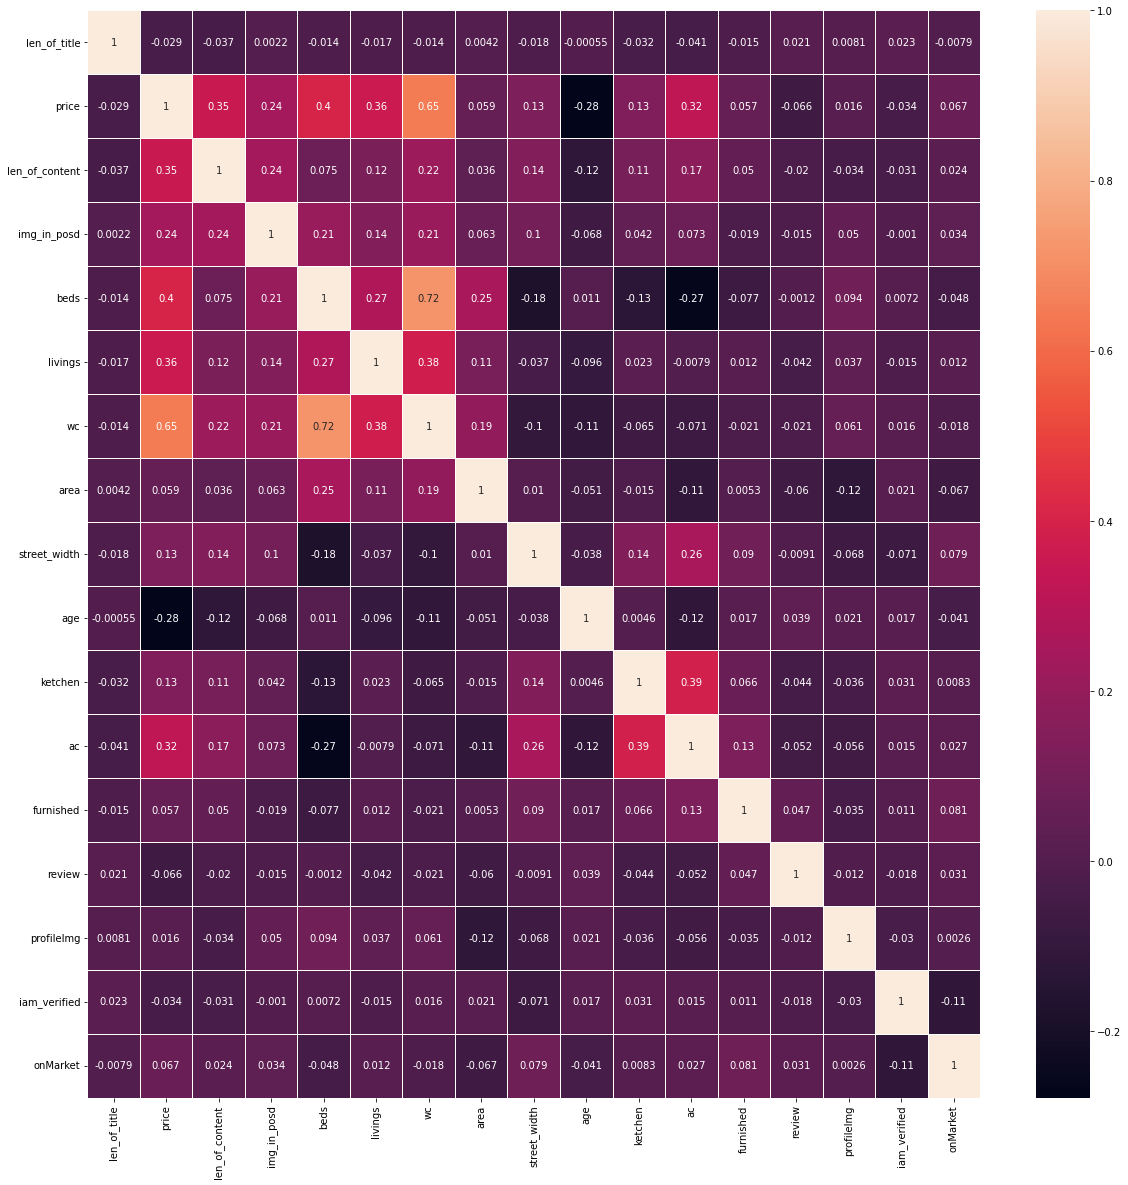

In [335]:
df1 = df.drop(['id',   'timeBeforeRent' ,  'isRent' ,'DayOfRent'    ] ,axis=1 )
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
dataplot = sns.heatmap(df1.corr() , annot=True, linewidths=.5, ax=ax)
# dataplot.set(rc={'figure.figsize':(11.7,8.27)})
# dataplot['figure.figsize'] = 11.7,8.27

<AxesSubplot:>

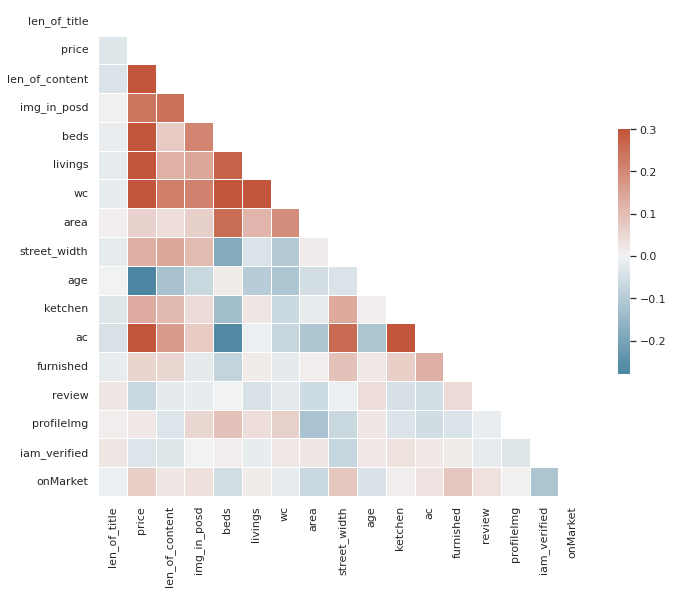

In [337]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
# rs = np.random.RandomState(33)
# d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                  columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [350]:
df.columns

Index(['user_id', 'id', 'len_of_title', 'price', 'len_of_content',
       'img_in_posd', 'beds', 'livings', 'wc', 'area', 'street_width', 'age',
       'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review',
       'profileImg', 'iam_verified', 'DayOfRent', 'onMarket', 'timeBeforeRent',
       'zone', 'isRent'],
      dtype='object')

In [355]:
df.drop('onMarket' , axis=1)

,user_id,id,len_of_title,price,len_of_content,img_in_posd,beds,livings,wc,area,...,furnished,district,advertiser_type,review,profileImg,iam_verified,DayOfRent,timeBeforeRent,zone,isRent
1,496663,4599813,59,25000,193,12,3,1.0,2,130.0,...,0.0,حي الفيحاء,exclusive_marketer,4.33,True,True,5,5,شرق,True
2,2412431,4554519,71,22000,140,8,3,1.0,2,200.0,...,0.0,حي الرمال,normal_marketer,4.67,False,True,2,15,شرق,True
4,970629,4578234,58,40000,268,11,3,1.0,2,170.0,...,0.0,حي الياسمين,normal_marketer,4.47,True,False,1,7,شمال,True
7,2194407,4584116,54,40000,128,13,4,1.0,2,160.0,...,0.0,حي النرجس,normal_marketer,4.79,True,True,13,18,شمال,True
8,2196933,4581609,60,19000,260,8,1,0.0,1,150.0,...,0.0,حي اشبيلية,owner,4.29,False,True,12,17,شرق,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,2185166,4509042,69,27000,313,0,2,1.0,1,75.0,...,0.0,حي القدس,normal_marketer,4.78,False,True,11,37,شرق,True
6092,901785,4384498,70,30000,205,0,1,1.0,1,80.0,...,0.0,حي العارض,owner,4.37,True,True,10,73,شمال,True
6095,1958104,4563570,59,60000,201,0,4,1.0,5,175.0,...,0.0,حي الياسمين,exclusive_marketer,4.31,True,True,8,18,شمال,True
6097,2441326,4504535,61,75000,251,0,3,1.0,2,175.0,...,0.0,حي القيروان,normal_marketer,3.74,True,True,9,39,شمال,True


-----------

In [230]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['onMarket', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [231]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train_df, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)
y = train_df.loc[:, 'onMarket']
X_test = data_proc.preprocess(test_df, train=False, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

X: (2093, 896) 
y: (2093,) 
X_test: (524, 896)


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [232]:
# convert all of our categorical columns to ints before using GBMs
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)


In [233]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X_train: (1674, 896) 
y_train: (1674,) 
X_val: (419, 896), 
y_val: (419,)


In [234]:
_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

((105, 896), (105,))

In [235]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

((84, 896), (21, 896), (84,), (21,))

In [236]:
cb_reg_1 = CatBoostRegressor( random_seed=13, verbose=200)

In [237]:
cb_reg_1.fit(X_train, y_train)
cb_preds = cb_reg_1.predict(X_val)

Learning rate set to 0.044415
0:	learn: 17.5810244	total: 2.79ms	remaining: 2.79s
200:	learn: 14.0247926	total: 378ms	remaining: 1.5s
400:	learn: 12.4640460	total: 731ms	remaining: 1.09s
600:	learn: 11.3169647	total: 1.09s	remaining: 724ms
800:	learn: 10.2929270	total: 1.44s	remaining: 358ms
999:	learn: 9.4109362	total: 1.8s	remaining: 0us


In [238]:
cb_preds = cb_reg_1.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(cb_preds, y_val))

15.73320189679597

In [239]:
params = {'loss_function':'RMSE', 'verbose': 200, 'random_seed': 13}

X_pool = Pool(data=X, label=y, cat_features=data_proc.final_cat_cols)

In [240]:
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'n_estimators': 100, 'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [241]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [242]:
obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
                          trials=Trials(), algo=tpe.suggest, max_evals=100)
print("----------------\n",catboost_opt)


100%|██████████| 100/100 [00:18<00:00,  5.40trial/s, best loss: 12.649515972052196]
----------------
 ({'colsample_bylevel': 0, 'learning_rate': 5, 'max_depth': 9}, <hyperopt.base.Trials object at 0x7f89e7bc87c0>)


In [243]:
cb_learn_rate = 0.002
n_iterations = 800000
early_stop_rounds = 4800

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                    #    'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 13}

In [244]:
cb_reg = CatBoostRegressor()

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055211
0:	learn: 17.5724495	test: 17.8483416	best: 17.8483416 (0)	total: 2ms	remaining: 1.99s
1:	learn: 17.5054051	test: 17.8166618	best: 17.8166618 (1)	total: 4.03ms	remaining: 2.01s
2:	learn: 17.4515727	test: 17.7863592	best: 17.7863592 (2)	total: 6.17ms	remaining: 2.05s
3:	learn: 17.4182106	test: 17.7514500	best: 17.7514500 (3)	total: 8.42ms	remaining: 2.1s
4:	learn: 17.3678000	test: 17.7321964	best: 17.7321964 (4)	total: 10.6ms	remaining: 2.1s
5:	learn: 17.3308765	test: 17.6971836	best: 17.6971836 (5)	total: 15.5ms	remaining: 2.57s
6:	learn: 17.2863803	test: 17.6863030	best: 17.6863030 (6)	total: 18.1ms	remaining: 2.57s
7:	learn: 17.2272886	test: 17.6470666	best: 17.6470666 (7)	total: 20.1ms	remaining: 2.49s
8:	learn: 17.1791537	test: 17.6258779	best: 17.6258779 (8)	total: 21.9ms	remaining: 2.41s
9:	learn: 17.1301451	test: 17.6015128	best: 17.6015128 (9)	total: 23.8ms	remaining: 2.35s
10:	learn: 17.0959364	test: 17.5938762	best: 17.5938762 (10)	total: 26ms	re

In [245]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, y_val))

15.561295136073483

In [246]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

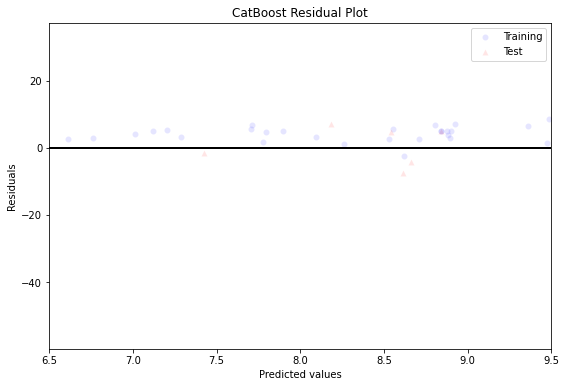

In [247]:
train_preds = cb_reg.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000], 
              y_val[:10000], val_preds[:10000], 
              title="CatBoost Residual Plot")

In [248]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,len_of_content,5.761227
1,price,5.286588
2,pca_10,4.628413
3,pca_6,4.357469
4,pca_2,3.979073
...,...,...
891,x1_حي ظهرة البديعة,0.000000
892,x1_حي عتيقة,0.000000
893,x1_حي غبيرة,0.000000
894,x1_حي منفوحة,0.000000


Text(0.5, 1.0, 'CatBoost features importance:')

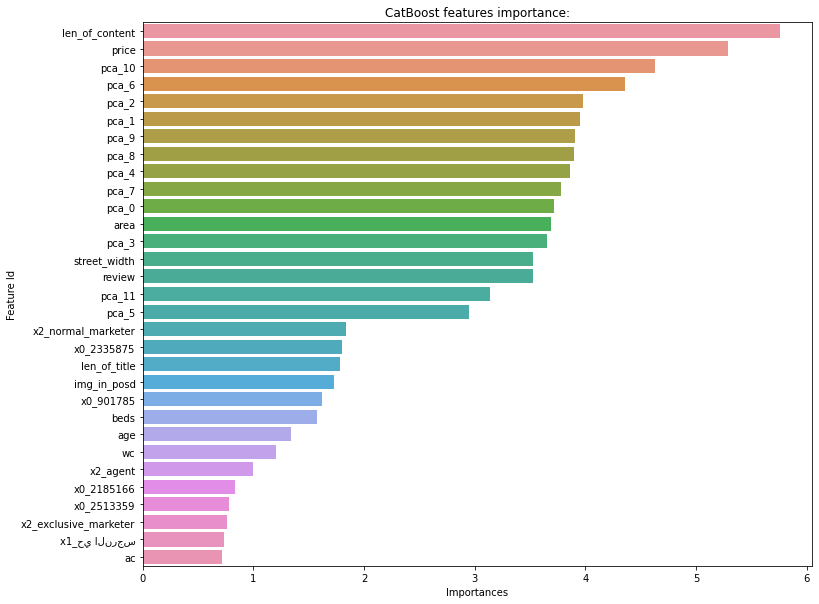

In [249]:
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

In [250]:
train_data = Pool(data=X_train, label=y_train)

val_data = Pool(data=X_val, label=y_val)

In [254]:
explainer = shap.TreeExplainer(cb_reg_1) 
shap_values = explainer.shap_values(train_data)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

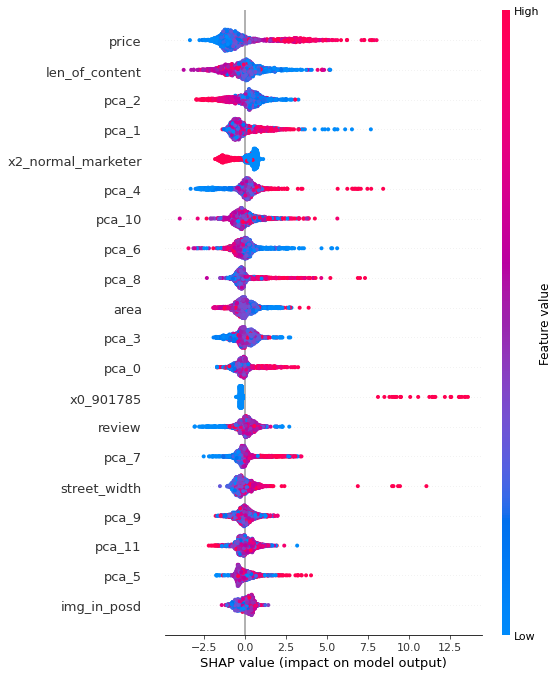

In [255]:
shap.summary_plot(shap_values, X_train)

In [262]:
N_FOLDS =5
k_folds = KFold(n_splits=N_FOLDS, shuffle=True)

# convert y values into appropriate form
y_array = y.values.reshape(-1, 1)

In [263]:
model_rmses = []
test_preds = np.zeros((X_test.shape[0], 1))

for train_idx, val_idx in tqdm(k_folds.split(X, y)):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split = X.iloc[val_idx].copy()
    val_labels = y.iloc[val_idx].astype(np.float64).copy()
    
    temp_model = CatBoostRegressor()
    
    # train model for 100 epochs with early stopping
    temp_model.fit(train_split, train_labels, 
               eval_set=(val_split, val_labels), 
               use_best_model=True,
               early_stopping_rounds=early_stop_rounds)
    
    # find log loss for out of fold val data
    model_val_preds = temp_model.predict(val_split)
    
    # calculate mean squared error on val sub-set preds
    fold_rmse = np.sqrt(mean_squared_error(model_val_preds, val_labels))
    model_rmses.append(fold_rmse)
    print(f'Current Fold validation RMSE: {fold_rmse:.4f}')
    
    # make predictions on test set for each fold
    temp_test_preds = temp_model.predict(X_test).reshape(-1, 1)
    test_preds += (temp_test_preds / N_FOLDS)

# convert results to np array
model_rmses = np.array(model_rmses)


0it [00:00, ?it/s]

Learning rate set to 0.055211
0:	learn: 17.6045310	test: 17.7513624	best: 17.7513624 (0)	total: 2.35ms	remaining: 2.35s
1:	learn: 17.5407024	test: 17.6959522	best: 17.6959522 (1)	total: 4.57ms	remaining: 2.28s
2:	learn: 17.5070738	test: 17.6698714	best: 17.6698714 (2)	total: 6.46ms	remaining: 2.15s
3:	learn: 17.4593753	test: 17.6390969	best: 17.6390969 (3)	total: 8.31ms	remaining: 2.07s
4:	learn: 17.4025492	test: 17.6030013	best: 17.6030013 (4)	total: 10.2ms	remaining: 2.03s
5:	learn: 17.3525840	test: 17.5664799	best: 17.5664799 (5)	total: 12.2ms	remaining: 2.02s
6:	learn: 17.3008174	test: 17.5319307	best: 17.5319307 (6)	total: 14.1ms	remaining: 2s
7:	learn: 17.2568707	test: 17.4995462	best: 17.4995462 (7)	total: 16ms	remaining: 1.99s
8:	learn: 17.1886549	test: 17.4634546	best: 17.4634546 (8)	total: 17.9ms	remaining: 1.98s
9:	learn: 17.1523347	test: 17.4348016	best: 17.4348016 (9)	total: 19.9ms	remaining: 1.97s
10:	learn: 17.1174484	test: 17.4316945	best: 17.4316945 (10)	total: 21.7ms	

1it [00:02,  2.38s/it]

969:	learn: 8.3510681	test: 15.6126811	best: 15.6054722 (964)	total: 1.92s	remaining: 59.5ms
970:	learn: 8.3333347	test: 15.6133322	best: 15.6054722 (964)	total: 1.93s	remaining: 57.5ms
971:	learn: 8.3318570	test: 15.6112237	best: 15.6054722 (964)	total: 1.93s	remaining: 55.6ms
972:	learn: 8.3305985	test: 15.6112242	best: 15.6054722 (964)	total: 1.93s	remaining: 53.6ms
973:	learn: 8.3269842	test: 15.6115659	best: 15.6054722 (964)	total: 1.93s	remaining: 51.6ms
974:	learn: 8.3257239	test: 15.6115695	best: 15.6054722 (964)	total: 1.93s	remaining: 49.6ms
975:	learn: 8.3244663	test: 15.6114633	best: 15.6054722 (964)	total: 1.94s	remaining: 47.6ms
976:	learn: 8.3184594	test: 15.6119968	best: 15.6054722 (964)	total: 1.94s	remaining: 45.6ms
977:	learn: 8.3172086	test: 15.6126135	best: 15.6054722 (964)	total: 1.94s	remaining: 43.7ms
978:	learn: 8.3111796	test: 15.6137678	best: 15.6054722 (964)	total: 1.94s	remaining: 41.7ms
979:	learn: 8.3013869	test: 15.6096886	best: 15.6054722 (964)	total: 1

2it [00:04,  2.33s/it]

937:	learn: 8.7161322	test: 14.8681452	best: 14.8658405 (933)	total: 1.93s	remaining: 128ms
938:	learn: 8.7147989	test: 14.8670645	best: 14.8658405 (933)	total: 1.94s	remaining: 126ms
939:	learn: 8.7134903	test: 14.8656723	best: 14.8656723 (939)	total: 1.94s	remaining: 124ms
940:	learn: 8.7034216	test: 14.8625041	best: 14.8625041 (940)	total: 1.94s	remaining: 122ms
941:	learn: 8.7016668	test: 14.8634779	best: 14.8625041 (940)	total: 1.94s	remaining: 120ms
942:	learn: 8.6903132	test: 14.8701786	best: 14.8625041 (940)	total: 1.94s	remaining: 118ms
943:	learn: 8.6889848	test: 14.8702038	best: 14.8625041 (940)	total: 1.95s	remaining: 115ms
944:	learn: 8.6876780	test: 14.8702152	best: 14.8625041 (940)	total: 1.95s	remaining: 113ms
945:	learn: 8.6836839	test: 14.8690946	best: 14.8625041 (940)	total: 1.95s	remaining: 111ms
946:	learn: 8.6816712	test: 14.8692050	best: 14.8625041 (940)	total: 1.95s	remaining: 109ms
947:	learn: 8.6801373	test: 14.8704760	best: 14.8625041 (940)	total: 1.96s	remai

3it [00:06,  2.25s/it]

988:	learn: 8.3930372	test: 16.0526821	best: 16.0444608 (934)	total: 1.92s	remaining: 21.4ms
989:	learn: 8.3902592	test: 16.0534891	best: 16.0444608 (934)	total: 1.92s	remaining: 19.4ms
990:	learn: 8.3890533	test: 16.0534802	best: 16.0444608 (934)	total: 1.93s	remaining: 17.5ms
991:	learn: 8.3880003	test: 16.0539170	best: 16.0444608 (934)	total: 1.93s	remaining: 15.6ms
992:	learn: 8.3868003	test: 16.0539088	best: 16.0444608 (934)	total: 1.93s	remaining: 13.6ms
993:	learn: 8.3856043	test: 16.0539022	best: 16.0444608 (934)	total: 1.93s	remaining: 11.7ms
994:	learn: 8.3843727	test: 16.0531835	best: 16.0444608 (934)	total: 1.93s	remaining: 9.72ms
995:	learn: 8.3825850	test: 16.0546651	best: 16.0444608 (934)	total: 1.94s	remaining: 7.77ms
996:	learn: 8.3728839	test: 16.0566755	best: 16.0444608 (934)	total: 1.94s	remaining: 5.83ms
997:	learn: 8.3716789	test: 16.0567752	best: 16.0444608 (934)	total: 1.94s	remaining: 3.89ms
998:	learn: 8.3704443	test: 16.0558464	best: 16.0444608 (934)	total: 1

4it [00:09,  2.23s/it]

994:	learn: 8.2287226	test: 15.1690697	best: 15.1669504 (986)	total: 1.97s	remaining: 9.9ms
995:	learn: 8.2275328	test: 15.1691279	best: 15.1669504 (986)	total: 1.97s	remaining: 7.92ms
996:	learn: 8.2265244	test: 15.1689044	best: 15.1669504 (986)	total: 1.97s	remaining: 5.94ms
997:	learn: 8.2138681	test: 15.1693466	best: 15.1669504 (986)	total: 1.98s	remaining: 3.96ms
998:	learn: 8.2128055	test: 15.1689264	best: 15.1669504 (986)	total: 1.98s	remaining: 1.98ms
999:	learn: 8.2009213	test: 15.1737868	best: 15.1669504 (986)	total: 1.98s	remaining: 0us

bestTest = 15.16695038
bestIteration = 986

Shrink model to first 987 iterations.
Current Fold validation RMSE: 15.1670
Learning rate set to 0.055216
0:	learn: 17.5172201	test: 18.0562683	best: 18.0562683 (0)	total: 2.17ms	remaining: 2.16s
1:	learn: 17.4340859	test: 18.0215915	best: 18.0215915 (1)	total: 4.56ms	remaining: 2.27s
2:	learn: 17.3667438	test: 18.0070967	best: 18.0070967 (2)	total: 6.58ms	remaining: 2.19s
3:	learn: 17.3301452	test

5it [00:11,  2.24s/it]

929:	learn: 8.8169517	test: 16.0694501	best: 16.0679439 (917)	total: 1.79s	remaining: 135ms
930:	learn: 8.8102339	test: 16.0676577	best: 16.0676577 (930)	total: 1.79s	remaining: 133ms
931:	learn: 8.8068108	test: 16.0673746	best: 16.0673746 (931)	total: 1.8s	remaining: 131ms
932:	learn: 8.7818108	test: 16.0618640	best: 16.0618640 (932)	total: 1.8s	remaining: 129ms
933:	learn: 8.7628868	test: 16.0572393	best: 16.0572393 (933)	total: 1.8s	remaining: 127ms
934:	learn: 8.7615159	test: 16.0572812	best: 16.0572393 (933)	total: 1.8s	remaining: 125ms
935:	learn: 8.7601039	test: 16.0573932	best: 16.0572393 (933)	total: 1.8s	remaining: 123ms
936:	learn: 8.7576076	test: 16.0561076	best: 16.0561076 (936)	total: 1.81s	remaining: 122ms
937:	learn: 8.7562641	test: 16.0561427	best: 16.0561076 (936)	total: 1.81s	remaining: 120ms
938:	learn: 8.7432481	test: 16.0476895	best: 16.0476895 (938)	total: 1.81s	remaining: 118ms
939:	learn: 8.7419187	test: 16.0476609	best: 16.0476609 (939)	total: 1.81s	remaining:

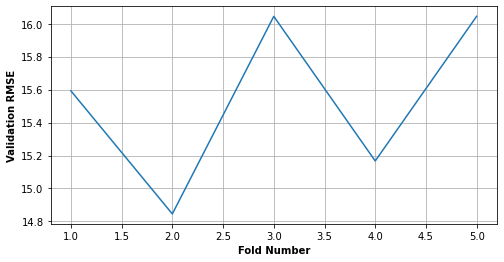

In [264]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, model_rmses.shape[0]+1), y=model_rmses)
plt.xlabel("Fold Number", weight='bold')
plt.ylabel("Validation RMSE", weight='bold')
plt.grid()
plt.show()

---------


In [140]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

2022-08-22 08:59:57.707316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-22 08:59:57.707429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [281]:
lRegressor = LinearRegression()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lRegressor", lRegressor),
])
model_pipeline.fit(X_train, y_train)
lgbmError = np.sqrt(mean_squared_error(y_test, model_pipeline.predict(X_test)))
lgbmError

982275938595068.1

In [280]:
from lightgbm import LGBMRegressor

lgbmRegressor = LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbmRegressor", lgbmRegressor),
])
model_pipeline.fit(X_train, y_train)
lgbmError = np.sqrt(mean_squared_error(y_test, model_pipeline.predict(X_test)))
lgbmError

15.754667289723242

In [278]:
from lightgbm import LGBMRegressor

lgbmRegressor = LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbmRegressor", lgbmRegressor),
])
model_pipeline.fit(X_train, y_train)
lgbmError = np.sqrt(mean_squared_error(y_test, model_pipeline.predict(X_test)))
lgbmError

15.754667289723242

In [282]:
from xgboost import XGBRegressor

In [287]:

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# defining model
xgbreg = XGBRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgbreg", xgbreg),
])
# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(model_pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
# print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

In [288]:
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

Scores - [17.60371562 16.11362834 15.65406529 15.69475679 18.03224511]
Mean - 16.619682229128486


In [293]:
def Objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 250, 300]),
        "eta": trial.suggest_loguniform("eta",1e-2,0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "max_depth": trial.suggest_categorical("max_depth",[5,7,9,11,13]),
        "random_state": 2021
    }
    
    model = XGBRegressor(**params)
    
    model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
     ("model", model),
    ])
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error'))
    
    return sum(scores)/len(scores)

In [294]:
import optuna

In [296]:
study = optuna.create_study(direction="minimize", study_name='Xgboost optimization')
study.optimize(Objective, n_trials=10)

[I 2022-08-22 09:50:36,608] A new study created in memory with name: Xgboost optimization
[I 2022-08-22 09:57:53,886] Trial 0 finished with value: 16.00193433172048 and parameters: {'n_estimators': 300, 'eta': 0.010866380306593886, 'subsample': 0.7, 'min_child_weight': 6, 'colsample_bytree': 0.7, 'max_depth': 13}. Best is trial 0 with value: 16.00193433172048.
[I 2022-08-22 10:02:40,087] Trial 1 finished with value: 16.055993370943053 and parameters: {'n_estimators': 200, 'eta': 0.02235538845138599, 'subsample': 0.7, 'min_child_weight': 9, 'colsample_bytree': 0.8, 'max_depth': 13}. Best is trial 0 with value: 16.00193433172048.
[I 2022-08-22 10:12:03,696] Trial 2 finished with value: 16.04852710886248 and parameters: {'n_estimators': 300, 'eta': 0.02189049742145829, 'subsample': 0.9, 'min_child_weight': 11, 'colsample_bytree': 0.6, 'max_depth': 13}. Best is trial 0 with value: 16.00193433172048.
[I 2022-08-22 10:14:11,688] Trial 3 finished with value: 16.286115746176158 and parameters:

In [297]:
XGB_params = study.best_params

study.best_params

{'n_estimators': 300,
 'eta': 0.010866380306593886,
 'subsample': 0.7,
 'min_child_weight': 6,
 'colsample_bytree': 0.7,
 'max_depth': 13}

# LightGBM

In [300]:
import lightgbm as lgbm

In [303]:
lgbreg = lgbm.LGBMRegressor()
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lgbreg", lgbreg),
])
# taking positive because cross val score returns -ve values
scores = np.abs(cross_val_score(model_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

Scores - [16.27390881 16.22643001 17.09443563 16.31878991 16.67438762]
Mean - 16.517590395458484


In [307]:
def Objective(trial):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMRegressor(**params)
    model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", model),
])
    
    # taking positive because cross val score returns -ve values
    scores = np.abs(cross_val_score(model_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error'))
    
    return sum(scores)/len(scores)

In [308]:
study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
study.optimize(Objective, n_trials=20)

[I 2022-08-22 10:43:40,386] A new study created in memory with name: LGBM optimization


[LightGBM] [Warning] lambda_l1 is set=2.7402342614979762e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7402342614979762e-05
[LightGBM] [Warning] feature_fraction is set=0.8415046642663029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415046642663029
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.5928625001231593e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5928625001231593e-06
[LightGBM] [Warning] bagging_fraction is set=0.5096474994531272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096474994531272
[LightGBM] [Warning] lambda_l1 is set=2.7402342614979762e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7402342614979762e-05
[LightGBM] [Warning] feature_fraction is set=0.8415046642663029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415046642663029
[LightGBM] [W

[I 2022-08-22 10:43:49,766] Trial 0 finished with value: 16.95516999819726 and parameters: {'lambda_l1': 2.7402342614979762e-05, 'lambda_l2': 3.5928625001231593e-06, 'num_leaves': 43, 'feature_fraction': 0.8415046642663029, 'bagging_fraction': 0.5096474994531272, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 0 with value: 16.95516999819726.


[LightGBM] [Warning] lambda_l1 is set=2.7402342614979762e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7402342614979762e-05
[LightGBM] [Warning] feature_fraction is set=0.8415046642663029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415046642663029
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.5928625001231593e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5928625001231593e-06
[LightGBM] [Warning] bagging_fraction is set=0.5096474994531272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096474994531272
[LightGBM] [Warning] lambda_l1 is set=6.505814841023463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.505814841023463e-08
[LightGBM] [Warning] feature_fraction is set=0.7477882203900823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477882203900823
[LightGBM] [War

[I 2022-08-22 10:43:59,114] Trial 1 finished with value: 16.778309924819613 and parameters: {'lambda_l1': 6.505814841023463e-08, 'lambda_l2': 0.007816944627946415, 'num_leaves': 24, 'feature_fraction': 0.7477882203900823, 'bagging_fraction': 0.597686746726234, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=6.505814841023463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.505814841023463e-08
[LightGBM] [Warning] feature_fraction is set=0.7477882203900823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477882203900823
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.007816944627946415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007816944627946415
[LightGBM] [Warning] bagging_fraction is set=0.597686746726234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.597686746726234
[LightGBM] [Warning] lambda_l1 is set=3.211483990709212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.211483990709212e-08
[LightGBM] [Warning] feature_fraction is set=0.8985129215651474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8985129215651474
[LightGBM] [Warning] ba

[I 2022-08-22 10:44:08,051] Trial 2 finished with value: 16.906098816582535 and parameters: {'lambda_l1': 3.211483990709212e-08, 'lambda_l2': 0.00020775407798298494, 'num_leaves': 7, 'feature_fraction': 0.8985129215651474, 'bagging_fraction': 0.815473717827985, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=3.211483990709212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.211483990709212e-08
[LightGBM] [Warning] feature_fraction is set=0.8985129215651474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8985129215651474
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00020775407798298494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020775407798298494
[LightGBM] [Warning] bagging_fraction is set=0.815473717827985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815473717827985
[LightGBM] [Warning] lambda_l1 is set=2.8057935608313563e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8057935608313563e-06
[LightGBM] [Warning] feature_fraction is set=0.6900208573328441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6900208573328441
[LightGBM] [Warni

[I 2022-08-22 10:44:17,191] Trial 3 finished with value: 17.06141545949685 and parameters: {'lambda_l1': 2.8057935608313563e-06, 'lambda_l2': 0.16669166997316423, 'num_leaves': 239, 'feature_fraction': 0.6900208573328441, 'bagging_fraction': 0.5428064145150095, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=2.8057935608313563e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8057935608313563e-06
[LightGBM] [Warning] feature_fraction is set=0.6900208573328441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6900208573328441
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.16669166997316423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16669166997316423
[LightGBM] [Warning] bagging_fraction is set=0.5428064145150095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428064145150095
[LightGBM] [Warning] lambda_l1 is set=1.8673527684050842e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8673527684050842e-08
[LightGBM] [Warning] feature_fraction is set=0.6238065365021075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238065365021075
[LightGBM] [Warning

[I 2022-08-22 10:44:26,365] Trial 4 finished with value: 17.016611984636988 and parameters: {'lambda_l1': 1.8673527684050842e-08, 'lambda_l2': 0.004369610640354481, 'num_leaves': 202, 'feature_fraction': 0.6238065365021075, 'bagging_fraction': 0.6738949281277167, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=1.8673527684050842e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8673527684050842e-08
[LightGBM] [Warning] feature_fraction is set=0.6238065365021075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238065365021075
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.004369610640354481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004369610640354481
[LightGBM] [Warning] bagging_fraction is set=0.6738949281277167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6738949281277167
[LightGBM] [Warning] lambda_l1 is set=1.0698286202682491e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0698286202682491e-07
[LightGBM] [Warning] feature_fraction is set=0.8117512037051458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117512037051458
[LightGBM] [Warni

[I 2022-08-22 10:44:35,989] Trial 5 finished with value: 16.818808761873534 and parameters: {'lambda_l1': 1.0698286202682491e-07, 'lambda_l2': 0.08982123996130807, 'num_leaves': 229, 'feature_fraction': 0.8117512037051458, 'bagging_fraction': 0.8206420344237231, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=1.0698286202682491e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0698286202682491e-07
[LightGBM] [Warning] feature_fraction is set=0.8117512037051458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117512037051458
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.08982123996130807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08982123996130807
[LightGBM] [Warning] bagging_fraction is set=0.8206420344237231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206420344237231
[LightGBM] [Warning] lambda_l1 is set=0.0001895065125662351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001895065125662351
[LightGBM] [Warning] feature_fraction is set=0.6669986257056448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6669986257056448
[LightGBM] [Warning] 

[I 2022-08-22 10:44:45,250] Trial 6 finished with value: 16.846090772812268 and parameters: {'lambda_l1': 0.0001895065125662351, 'lambda_l2': 1.5865168955710668e-06, 'num_leaves': 116, 'feature_fraction': 0.6669986257056448, 'bagging_fraction': 0.9033238633187448, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=0.0001895065125662351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001895065125662351
[LightGBM] [Warning] feature_fraction is set=0.6669986257056448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6669986257056448
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.5865168955710668e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5865168955710668e-06
[LightGBM] [Warning] bagging_fraction is set=0.9033238633187448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9033238633187448
[LightGBM] [Warning] lambda_l1 is set=0.2671422830983589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2671422830983589
[LightGBM] [Warning] feature_fraction is set=0.8243532893712776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243532893712776
[LightGBM] [Warning] ba

[I 2022-08-22 10:44:54,502] Trial 7 finished with value: 17.270938895332048 and parameters: {'lambda_l1': 0.2671422830983589, 'lambda_l2': 8.405398888995286, 'num_leaves': 81, 'feature_fraction': 0.8243532893712776, 'bagging_fraction': 0.4714138436737916, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=0.2671422830983589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2671422830983589
[LightGBM] [Warning] feature_fraction is set=0.8243532893712776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243532893712776
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.405398888995286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.405398888995286
[LightGBM] [Warning] bagging_fraction is set=0.4714138436737916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4714138436737916
[LightGBM] [Warning] lambda_l1 is set=0.0017175398859822551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017175398859822551
[LightGBM] [Warning] feature_fraction is set=0.6655649596990514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6655649596990514
[LightGBM] [Warning] bagging_freq

[I 2022-08-22 10:45:03,640] Trial 8 finished with value: 17.032460934196624 and parameters: {'lambda_l1': 0.0017175398859822551, 'lambda_l2': 0.08566881572263238, 'num_leaves': 191, 'feature_fraction': 0.6655649596990514, 'bagging_fraction': 0.4885269772945691, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=0.0017175398859822551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017175398859822551
[LightGBM] [Warning] feature_fraction is set=0.6655649596990514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6655649596990514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.08566881572263238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08566881572263238
[LightGBM] [Warning] bagging_fraction is set=0.4885269772945691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4885269772945691
[LightGBM] [Warning] lambda_l1 is set=8.947548843819204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.947548843819204e-05
[LightGBM] [Warning] feature_fraction is set=0.9977662975891429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9977662975891429
[LightGBM] [Warning] ba

[I 2022-08-22 10:45:12,919] Trial 9 finished with value: 16.84886641095023 and parameters: {'lambda_l1': 8.947548843819204e-05, 'lambda_l2': 4.6273506586262005e-08, 'num_leaves': 180, 'feature_fraction': 0.9977662975891429, 'bagging_fraction': 0.5758324556695138, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 1 with value: 16.778309924819613.


[LightGBM] [Warning] lambda_l1 is set=8.947548843819204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.947548843819204e-05
[LightGBM] [Warning] feature_fraction is set=0.9977662975891429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9977662975891429
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.6273506586262005e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6273506586262005e-08
[LightGBM] [Warning] bagging_fraction is set=0.5758324556695138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758324556695138
[LightGBM] [Warning] lambda_l1 is set=3.9276144737999643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9276144737999643
[LightGBM] [Warning] feature_fraction is set=0.522962178304233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522962178304233
[LightGBM] [Warning] bagg

[I 2022-08-22 10:45:22,110] Trial 10 finished with value: 16.46633128570191 and parameters: {'lambda_l1': 3.9276144737999643, 'lambda_l2': 8.543167103459474e-05, 'num_leaves': 7, 'feature_fraction': 0.522962178304233, 'bagging_fraction': 0.6727019211506933, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 10 with value: 16.46633128570191.


[LightGBM] [Warning] lambda_l1 is set=3.9276144737999643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9276144737999643
[LightGBM] [Warning] feature_fraction is set=0.522962178304233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522962178304233
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.543167103459474e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.543167103459474e-05
[LightGBM] [Warning] bagging_fraction is set=0.6727019211506933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6727019211506933
[LightGBM] [Warning] lambda_l1 is set=1.7501647740634483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7501647740634483
[LightGBM] [Warning] feature_fraction is set=0.4503188669499304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503188669499304
[LightGBM] [Warning] bagging_freq

[I 2022-08-22 10:45:31,094] Trial 11 finished with value: 16.41278633733651 and parameters: {'lambda_l1': 1.7501647740634483, 'lambda_l2': 7.95242081989741e-05, 'num_leaves': 7, 'feature_fraction': 0.4503188669499304, 'bagging_fraction': 0.6729509684170443, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 11 with value: 16.41278633733651.


[LightGBM] [Warning] lambda_l1 is set=1.7501647740634483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7501647740634483
[LightGBM] [Warning] feature_fraction is set=0.4503188669499304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503188669499304
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.95242081989741e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.95242081989741e-05
[LightGBM] [Warning] bagging_fraction is set=0.6729509684170443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6729509684170443
[LightGBM] [Warning] lambda_l1 is set=8.284895107792892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.284895107792892
[LightGBM] [Warning] feature_fraction is set=0.43929213443411547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43929213443411547
[LightGBM] [Warning] bagging_freq

[I 2022-08-22 10:45:40,956] Trial 12 finished with value: 16.329712971672933 and parameters: {'lambda_l1': 8.284895107792892, 'lambda_l2': 5.504756444706943e-05, 'num_leaves': 61, 'feature_fraction': 0.43929213443411547, 'bagging_fraction': 0.7097367864205647, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.03734432850438114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03734432850438114
[LightGBM] [Warning] feature_fraction is set=0.4138965362498316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4138965362498316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1657064159738051e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1657064159738051e-05
[LightGBM] [Warning] bagging_fraction is set=0.7433305075360634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7433305075360634
[LightGBM] [Warning] lambda_l1 is set=0.03734432850438114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03734432850438114
[LightGBM] [Warning] feature_fraction is set=0.4138965362498316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4138965362498316
[LightGBM] [Warning] bagg

[I 2022-08-22 10:45:50,799] Trial 13 finished with value: 16.39705819611354 and parameters: {'lambda_l1': 0.03734432850438114, 'lambda_l2': 1.1657064159738051e-05, 'num_leaves': 76, 'feature_fraction': 0.4138965362498316, 'bagging_fraction': 0.7433305075360634, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.028913034590821236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028913034590821236
[LightGBM] [Warning] feature_fraction is set=0.40677649018085404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40677649018085404
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.428231451266965e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.428231451266965e-06
[LightGBM] [Warning] bagging_fraction is set=0.7804768475073882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7804768475073882
[LightGBM] [Warning] lambda_l1 is set=0.028913034590821236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028913034590821236
[LightGBM] [Warning] feature_fraction is set=0.40677649018085404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40677649018085404
[LightGBM] [Warning

[I 2022-08-22 10:46:00,219] Trial 14 finished with value: 16.61236589176591 and parameters: {'lambda_l1': 0.028913034590821236, 'lambda_l2': 1.428231451266965e-06, 'num_leaves': 75, 'feature_fraction': 0.40677649018085404, 'bagging_fraction': 0.7804768475073882, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.00471324344941092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00471324344941092
[LightGBM] [Warning] feature_fraction is set=0.5381049245274261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5381049245274261
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.9515055479898926e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9515055479898926e-08
[LightGBM] [Warning] bagging_fraction is set=0.7507933926937513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7507933926937513
[LightGBM] [Warning] lambda_l1 is set=0.00471324344941092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00471324344941092
[LightGBM] [Warning] feature_fraction is set=0.5381049245274261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5381049245274261
[LightGBM] [Warning] bagg

[I 2022-08-22 10:46:09,884] Trial 15 finished with value: 16.701327744052833 and parameters: {'lambda_l1': 0.00471324344941092, 'lambda_l2': 5.9515055479898926e-08, 'num_leaves': 136, 'feature_fraction': 0.5381049245274261, 'bagging_fraction': 0.7507933926937513, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.11243057415589976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11243057415589976
[LightGBM] [Warning] feature_fraction is set=0.520236681335796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.520236681335796
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3852535950974877e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3852535950974877e-05
[LightGBM] [Warning] bagging_fraction is set=0.9121229709991059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9121229709991059
[LightGBM] [Warning] lambda_l1 is set=0.11243057415589976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11243057415589976
[LightGBM] [Warning] feature_fraction is set=0.520236681335796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.520236681335796
[LightGBM] [Warning] bagging_

[I 2022-08-22 10:46:19,246] Trial 16 finished with value: 16.61904384623734 and parameters: {'lambda_l1': 0.11243057415589976, 'lambda_l2': 1.3852535950974877e-05, 'num_leaves': 70, 'feature_fraction': 0.520236681335796, 'bagging_fraction': 0.9121229709991059, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=7.316576799268958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.316576799268958
[LightGBM] [Warning] feature_fraction is set=0.40459787732928043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40459787732928043
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0013871164713258257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013871164713258257
[LightGBM] [Warning] bagging_fraction is set=0.9822112986915235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9822112986915235
[LightGBM] [Warning] lambda_l1 is set=7.316576799268958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.316576799268958
[LightGBM] [Warning] feature_fraction is set=0.40459787732928043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40459787732928043
[LightGBM] [Warning] bagging_fr

[I 2022-08-22 10:46:29,166] Trial 17 finished with value: 16.435406830700583 and parameters: {'lambda_l1': 7.316576799268958, 'lambda_l2': 0.0013871164713258257, 'num_leaves': 122, 'feature_fraction': 0.40459787732928043, 'bagging_fraction': 0.9822112986915235, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.1825589951925644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1825589951925644
[LightGBM] [Warning] feature_fraction is set=0.5858301875638673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858301875638673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.9890569698711766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9890569698711766e-07
[LightGBM] [Warning] bagging_fraction is set=0.4043586087137575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4043586087137575
[LightGBM] [Warning] lambda_l1 is set=0.1825589951925644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1825589951925644
[LightGBM] [Warning] feature_fraction is set=0.5858301875638673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858301875638673
[LightGBM] [Warning] bagging_

[I 2022-08-22 10:46:38,265] Trial 18 finished with value: 17.149642477746813 and parameters: {'lambda_l1': 0.1825589951925644, 'lambda_l2': 2.9890569698711766e-07, 'num_leaves': 94, 'feature_fraction': 0.5858301875638673, 'bagging_fraction': 0.4043586087137575, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 12 with value: 16.329712971672933.


[LightGBM] [Warning] lambda_l1 is set=0.1825589951925644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1825589951925644
[LightGBM] [Warning] feature_fraction is set=0.5858301875638673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858301875638673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.9890569698711766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9890569698711766e-07
[LightGBM] [Warning] bagging_fraction is set=0.4043586087137575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4043586087137575
[LightGBM] [Warning] lambda_l1 is set=0.006592333789323485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006592333789323485
[LightGBM] [Warning] feature_fraction is set=0.4964423849616043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4964423849616043
[LightGBM] [Warning] bagg

[I 2022-08-22 10:46:47,908] Trial 19 finished with value: 16.682051718181956 and parameters: {'lambda_l1': 0.006592333789323485, 'lambda_l2': 7.443544483793124e-06, 'num_leaves': 51, 'feature_fraction': 0.4964423849616043, 'bagging_fraction': 0.7171578099050927, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 12 with value: 16.329712971672933.


In [309]:
lgb_params = study.best_params
study.best_params

{'lambda_l1': 8.284895107792892,
 'lambda_l2': 5.504756444706943e-05,
 'num_leaves': 61,
 'feature_fraction': 0.43929213443411547,
 'bagging_fraction': 0.7097367864205647,
 'bagging_freq': 7,
 'min_child_samples': 5}

In [313]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
final_estimator = GradientBoostingRegressor(n_estimators=200, 
                                            random_state=42)

estimators = [('xgb', XGBRegressor( **XGB_params)),
              ('lgb', lgbm.LGBMRegressor(**lgb_params))]
model_pipeline = Pipeline(steps=[
("preprocessor", preprocessor),
("final_estimator", final_estimator),
])
reg = StackingRegressor(
        estimators=estimators,
         final_estimator=model_pipeline)

In [314]:
scores = np.abs(cross_val_score(reg, X, y, cv=kf, scoring='neg_root_mean_squared_error'))

# printing the output
print(f"Scores - {scores}\nMean - {sum(scores)/len(scores)}")

[LightGBM] [Fatal] Do not support non-ASCII characters in feature name.
[LightGBM] [Fatal] Do not support non-ASCII characters in feature name.
[LightGBM] [Fatal] Do not support non-ASCII characters in feature name.
[LightGBM] [Fatal] Do not support non-ASCII characters in feature name.
[LightGBM] [Fatal] Do not support non-ASCII characters in feature name.


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/ensemble/_stacking.py", line 866, in fit
    return super().fit(X, y, sample_weight)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/ensemble/_stacking.py", line 189, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/vscode/.local/lib/python3.10/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py", line 47, in _fit_single_estimator
    estimator.fit(X, y)
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 734, in fit
    super(LGBMRegressor, self).fit(X, y, sample_weight=sample_weight,
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 594, in fit
    self._Booster = train(params, train_set,
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 1081, in construct
    self._lazy_init(self.data, label=self.label,
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 915, in _lazy_init
    return self.set_feature_name(feature_name)
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 1365, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "/home/vscode/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 45, in _safe_call
    raise LightGBMError(decode_string(_LIB.LGBM_GetLastError()))
lightgbm.basic.LightGBMError: Do not support non-ASCII characters in feature name.
